In [1]:
#!pip3 install sklearn

In [2]:
import random, os
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

In [3]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [4]:
from pyspark.sql import SparkSession

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
    .config("spark.yarn.access.hadoopFileSystems",os.environ["STORAGE"])\
    .getOrCreate()
    #.config("spark.executor.memory","2g")\
    #.config("spark.executor.cores","8")\
    #.config("spark.driver.memory","2g")\

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


In [7]:
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

In [8]:
def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver//100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = spark.sparkContext.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [9]:
#df = spark.read.option('inferschema','true').csv('data/Data_Exploration.csv', header=True)

In [10]:
df = spark.sql("SELECT * FROM default.LC_Table")

Hive Session ID = 60a7a7e7-8eb7-44e0-a75f-0a218295e112


In [11]:
df.groupby("is_default").count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         1|10797|
|         0|68366|
+----------+-----+



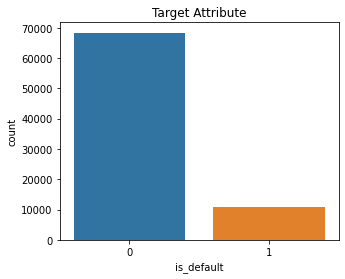

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(x=df.groupby("is_default").count().toPandas()["is_default"], y=df.groupby("is_default").count().toPandas()["count"]).set(title="Target Attribute")
plt.show()

In [13]:
#We will drop this feature based on its imbalance
df.groupby('application_type').count().show()

+----------------+-----+
|application_type|count|
+----------------+-----+
|       Joint App|  407|
|      Individual|78756|
+----------------+-----+



In [14]:
#We will drop this feature for now although it could be one hot encoded or transformed differently
df.select('emp_length').show(5)

+----------+
|emp_length|
+----------+
| 10+ years|
|       n/a|
| 10+ years|
| 10+ years|
|   3 years|
+----------+
only showing top 5 rows



In [15]:
#We keep this feature
df.groupby('verification_status').count().show()

+-------------------+-----+
|verification_status|count|
+-------------------+-----+
|           Verified|25233|
|               null|    1|
|    Source Verified|32149|
|       Not Verified|21780|
+-------------------+-----+



In [16]:
#We remove categorical features that have too broad a set of values, or are highly imbalanced, or could cause data leakage. 
#We can elaborate and use them for feature extraction later, but they are not needed for a baseline

remove = ['addr_state', 'earliest_cr_line', 'home_ownership', 'initial_list_status', 'issue_d', 'emp_length',
          'loan_status', 'purpose', 'sub_grade', 'term', 'title', 'zip_code', 'application_type']
df = df.drop(*remove)

In [17]:
df = df.limit(1000)

In [18]:
len(df.columns)

58

In [19]:
#We will choose these features for our baseline model:
#Creating list of categorical and numeric features
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]
num_features, cat_features = num_cols, cat_cols

In [20]:
df = df.dropna()

In [21]:
df = df.select(num_features)

Baseline Feature Exploration

In [22]:
#Creates a Pipeline Object 
def make_pipeline_numeric(spark_df):        
    stages= []

    scale_cols = df.columns
    scale_cols.remove('is_default')
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=scale_cols, outputCol="features")
    stages += [assembler]
    
    #Standard scaler
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
    stages += [scaler]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)
    
    return out_df

In [23]:
df_model = make_pipeline_numeric(df)

In [24]:
input_data = df_model.rdd.map(lambda x: (x["is_default"], DenseVector(x["scaledFeatures"])))

In [25]:
df_pre_smote = spark.createDataFrame(input_data, ["is_default", "scaledFeatures"])

In [26]:
#scaledData = scaledData.drop("features")

In [27]:
df_pre_smote.show(5)

+----------+--------------------+
|is_default|      scaledFeatures|
+----------+--------------------+
|         0|[-0.0859076792580...|
|         0|[-0.0859076792580...|
|         1|[-0.0859076792580...|
|         0|[-0.0859076792580...|
|         1|[-0.0859076792580...|
+----------+--------------------+
only showing top 5 rows



In [28]:
df_smote = SmoteSampling(vectorizerFunction(df_pre_smote, 'is_default'), k = 3, minorityClass = 1, majorityClass = 0, percentageOver = 400, percentageUnder = 100)

In [29]:
df_pre_smote.groupby("is_default").count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         0|  674|
|         1|  127|
+----------+-----+



In [30]:
df_smote.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  635|
|    0|  709|
+-----+-----+



In [31]:
df_out = df_smote.groupby("label").count().toPandas()

In [32]:
df_out[df_out['label']==1]['count'][1]

617

In [33]:
df_pre = df_pre_smote.groupby("is_default").count().toPandas()
df_post = df_smote.groupby("label").count().toPandas()

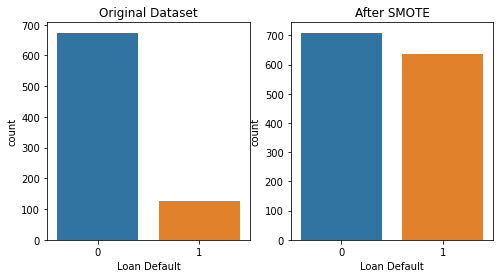

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=False)

ax1 = sns.barplot(x=df_pre["is_default"], y=df_pre["count"], ax=ax1).set(title="Original Dataset", xlabel='Loan Default')
ax2 = sns.barplot(x=df_post["label"],y=df_post["count"], ax=ax2).set(title="After SMOTE", xlabel='Loan Default')
plt.show()

In [35]:
scale_cols = df.columns
scale_cols.remove('is_default')

In [36]:
df_smote.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
|[-0.0859076792580...|    0|
+--------------------+-----+
only showing top 20 rows



In [37]:
def extract(row):
    return tuple(row.features.toArray().tolist()) + (row.label, )

In [38]:
df_smote_table = df_smote.rdd.map(extract).toDF(df.columns)

In [39]:
df_smote_table\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.lc_smote_subset'
)

In [40]:
spark.stop()